<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/HW_1107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07. 문서 군집화 소개와 실습(Opinion Review 데이터 세트)

### 문서 군집화 개념

* 비슷한 텍스트 구성의 문서를 군집화하는 것

* 동일한 군집에 속하는 문서를 같은 카테고리로 분류할 수 있다는 점에서 텍스트 분류 기반의 문서 분류와 유사

* 하지만 텍스트 분류 기반의 문서 분류는 사전에 결정 카테고리 값을 가진 학습 데이터가 필요하고, 문서 군집화는 학습 데이터 세트가 필요없는 **비지도학습** 기반으로 동작함

* 앞에서 배운 군집화 기법을 활용해 텍스트 기반의 문서 군집화 적용

### Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기

* 51개의 텍스트 파일로 구성

* 각 파일은 Tripadvisor(호텔), Edmunds.com(자동차), Amazon.com(전자제품) 사이트에서 가져온 리뷰 문서임

* 각 문서는 약 100개 정도의 문장을 가짐

1. Data Loading

In [ ]:
import pandas as pd
import glob, os

from google.colab import drive
drive.mount('/content/drive')

# setting directory
path = r'/content/drive/MyDrive/ESAAdata/OpinosisDataset1.0/topics'

# path로 지정한 directory 밑에 있는 모든 .data 파일의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path,'*.data'))
filename_list = []
opinion_text = []

# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string으로 변환해 opinion_text list로 취합
for file_ in all_files:
    ## 개별 파일을 읽어서 DataFrame으로 생성
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1') 
    ## 절대 경로로 주어진 파일명 가공, '.data' 확장자 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

# 파일명 list와 파일 내용 list 객체를 DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

Mounted at /content/drive


,filename,opinion_text
0,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...
1,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...
2,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...
3,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...
4,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...


2. TF-IDF 피처 벡터화

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)
    
    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)
    
    # 단어 원형 추출
    return LemTokens(word_tokens)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
# opinion_text 칼럼 값으로 피처 벡터화
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


3. 군집화

* 문서별 텍스트가 TF-IDF 변환된 피처 벡터화 행렬 데이터에 대해 군집화 수행

* K-평균 기법 적용

In [ ]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [ ]:
# 각 데이터별로 할당된 군집의 레이블을 document_df 데이터프레임의 'cluster_label' 칼럼으로 저장
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
1,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
2,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
3,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
4,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4


* 각 cluster_label마다 어떤 파일명으로 매칭됐는지 보고 군집화 결과 확인

In [ ]:
document_df[document_df['cluster_label']==0].sort_values(by='filename') #호텔에 대한 리뷰로 군집화됨

,filename,opinion_text,cluster_label
1,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
6,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
12,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
16,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
17,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
21,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
22,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
45,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
48,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0


In [ ]:
document_df[document_df['cluster_label']==1].sort_values(by='filename') #포터블 전자기기에 대한 리뷰

,filename,opinion_text,cluster_label
0,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
2,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
3,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
8,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
13,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,headphone jack i got a clear case for it a...,1
18,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
24,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
25,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
34,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
40,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1


In [ ]:
document_df[document_df['cluster_label']==2].sort_values(by='filename') #cluster 1과 비슷하지만 주로 차량용 네비게이션으로 군집이 구성됨

,filename,opinion_text,cluster_label
5,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
9,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
19,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
29,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
30,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
32,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
38,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
39,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
42,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
49,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2


In [ ]:
document_df[document_df['cluster_label']==3].sort_values(by='filename') #대부분 호텔에 대한 리뷰

,filename,opinion_text,cluster_label
7,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,3
28,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,3
31,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,3
43,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,3
44,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,3
50,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,3


In [ ]:
document_df[document_df['cluster_label']==4].sort_values(by='filename') #자동차에 대한 리뷰

,filename,opinion_text,cluster_label
4,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
10,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
11,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
14,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
15,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
20,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
23,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
26,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
27,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4
33,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,4


군집 개수가 많아서 세분화된 경향이 있으므로 중심 개수를 낮춰 3개 그룹으로 군집화하고 결과를 확인해보자.

In [ ]:
from sklearn.cluster import KMeans

# 3개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
32,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
30,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
5,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
29,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
9,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
19,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
38,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
42,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
49,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
39,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0


In [ ]:
document_df[document_df['cluster_label']==0].sort_values(by='filename') #포터블 전자기기

,filename,opinion_text,cluster_label
5,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
9,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
19,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
29,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
30,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
32,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
38,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
39,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
42,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0
49,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,0


In [ ]:
document_df[document_df['cluster_label']==1].sort_values(by='filename') #호텔

,filename,opinion_text,cluster_label
4,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
10,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
11,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
14,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
15,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
20,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
23,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
26,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
27,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1
33,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,1


In [ ]:
document_df[document_df['cluster_label']==2].sort_values(by='filename') #자동차

,filename,opinion_text,cluster_label
0,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
45,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
44,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
43,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
40,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
34,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
31,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
28,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
25,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2
24,/content/drive/MyDrive/ESAAdata/OpinosisDataset1,...,2


### 군집별 핵심 단어 추출하기

* KMeans 객체 clusters_centers 속성 : 단어 피처가 군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치하는지 배열 값을 제공(행 : 개별 군집, 열 : 개별 피처, 각 배열 내의 값 : 개별 군집 내의 상대 위치를 숫자로 표현한 좌표값)

In [ ]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape : ',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape :  (3, 4611)
[[0.         0.00092551 0.         ... 0.         0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.01005322 0.         0.         ... 0.00706287 0.         0.        ]]


shape이 (3,2409)이므로 군집이 3개, word 피처가 2409개로 구성되었음을 알 수 있다. 각 행의 배열 값은 각 군집 내 2409개 피처의 위치가 개별 중심과 얼마나 가까운지 상대적인 값으로 나타낸 것이다. 범위는 0~1이며 1에 가까울수록 중심과 가까운 값이다.

1. 각 군집별 핵심 단어 찾기

In [ ]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목들을 반환
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}

    ## cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    ## 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위해서
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:, ::-1]

    ## 개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목 입력
    for cluster_num in range(clusters_num):
        ### 개별 군집별 정보를 담을 데이터 초기화
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num

        ### cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [feature_names[ind] for ind in top_feature_indexes]

        ### top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()

        ### cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filename'] = filenames

    return cluster_details

In [ ]:
# 출력 결과를 보기 좋게 표현하는 함수 정의
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('filename :', cluster_detail['filename'][:7])
        print('==================================================')

In [ ]:
# 함수 호출 - TF-IDF 변환된 tfidf_vect 객체의 get_feature_names() 추출해 저장
feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,
                                     feature_names = feature_names, clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
filename : ['/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1']
####### Cluster 1
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
filename : ['/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyDrive/ESAAdata/OpinosisDataset1', '/content/drive/MyD

각 군집별 핵심 단어

* Cluster 0(포터블 전자제품) : 'screen', 'battery', 'life' 등 화면과 배터리 수명 관련

* Cluster 1(호텔) : 'room', 'hotel', 'service', 'location' 등 방과 서비스 관련

* Cluster 2(자동차) : 'interior', 'seat', 'mileage', 'comfortable' 등 실내 인테리어, 좌석, 연료 효율 관련

## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

* 일본의 대형 온라인 쇼핑몰 Mercari사의 제품 가격 예측 Challenge

* 데이터 타깃 값 : price(제품 가격)

* 회귀로 피처를 학습하고 price 예측

### 데이터 전처리

1. 데이터 분포, Null값 확인

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/ESAAdata/mercaridata/mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [ ]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


* brand_name 칼럼에 Null 값이 많음

* category_name 칼럼 null 데이터는 약 6300건

* item_description의 null 데이터는 4건으로 매우 적음

    -> Null 데이터는 이후에 적절한 문자열로 치환한다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


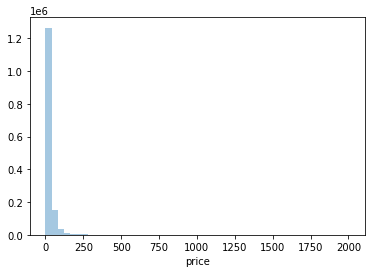

In [ ]:
# price 칼럼(target)의 분포

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포하므로 로그변환한다.

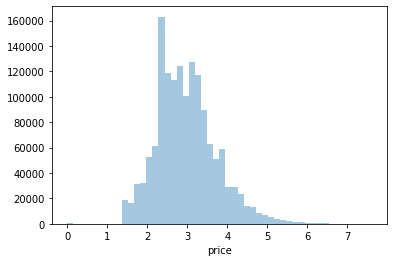

In [ ]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

In [ ]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [ ]:
# 다른 피처들의 값 살펴보기
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [ ]:
# description에 대한 별도 설명이 없는 값의 개수 - Null값과 마찬가지로 변경 필요
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

2. category name 처리

* category_name은 '/'로 분리된 카테고리를 하나의 문자열로 나타냄(대, 중, 소분류)

* '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘 학습

* category_name을 효과적으로 분리하기 위한 함수를 생성하여 dataframe에 적용해보자.


In [ ]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성하고 대, 중, 소 값을 리스트로 반환

def split_cat(category_name):
    try:
        return category_name.split('/')
    except: #category_name==Null인 경우 error를 except catch하여 3가지 분류 모두 'Other_Null'값 부여
        return ['Other_Null','Other_Null','Other_Null']

# 위 함수를 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x))) #리스트 요소를 여러 개의 칼럼으로 분리

# 대분류만 값의 유형과 건수를 살펴보고, 중분류와 소분류는 분류 개수만 추출
print('대분류 유형 :\n',mercari_df['cat_dae'].value_counts())
print('중분류 개수 :',mercari_df['cat_jung'].nunique())
print('소분류 개수 :',mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


결과

* 대분류의 경우 Women, Beauty, Kids가 매우 많음

* 중분류, 소분류 유형 각 114, 817개

3. Null값 처리

* brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other_Null'로 변경

* brand_name은 price 결정에 많은 영향을 줄 것으로 예상되므로 Null 값을 다르게 변경하는 것은 적절하지 않음 -> 'Other_Null'로 대체

In [ ]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화

* 문자열 칼럼 중 레이블/원핫인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별해보자.

* 가격 예측이므로 회귀 모델 기반(선형 회귀, 회귀 트리 모두 적용), 선형 회귀 수행 예정이므로 일괄적으로 원핫인코딩 적용

* 짧은 텍스트는 Count 기반, 긴 텍스트는 TF-IDF 기반 벡터화 적용

1. brand_name(상품의 브랜드명)

In [ ]:
print('brand name의 유형 건수 : ',mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n',mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 :  4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


* 대부분 명료한 문자열로 되어 있어 피처 벡터화 필요 없이 인코딩 적용

2. name(상품명)

In [ ]:
print('name의 종류 개수 : ',mercari_df['name'].nunique())
print('name sample 10건 : \n',mercari_df['name'][:10])

name의 종류 개수 :  1225273
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


* 유형이 매우 다양, 적은 단어 위주의 텍스트 -> Count 기반 피처 벡터화

3. category_name이 분리된 cat_dae/jung/so

4. shipping(배송비 무료 여부, 0과 1)

5. item_condition_id(상품 상태, 1~5)

    -> 모두 원핫인코딩


6. item_description(상품 설명)

In [ ]:
pd.set_option('max_colwidth',200)

# item_description의 평균 문자열 크기
print('item_description의 평균 문자열 크기 : ',mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description의 평균 문자열 크기 :  145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

* TF-IDF 변환 적용

주요 칼럼을 인코딩 및 피처 벡터화 변환

In [ ]:
# name
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description
tfidf_descp = TfidfVectorizer(max_features=50000,ngram_range=(1,3),stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape : ',X_name.shape)
print('item_description vectorization shpae : ',X_descp.shape)

name vectorization shape :  (1482535, 105757)
item_description vectorization shpae :  (1482535, 50000)


* fit_transform() -> 희소 행렬 형태 반환

* 희소 행렬 객체 변수 X_name, X_descp를 결합해 새로운 데이터 세트 구성, 앞으로 인코딩할 피처들도 이와 결합해 새로운 데이터 세트를 구성해야 함 -> 인코딩 대상 칼럼도 희소 행렬 형태로 인코딩 적용

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 희소행렬 원핫인코딩
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae/jung/so 희소행렬 원핫인코딩
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

# 확인
print(type(X_brand),type(X_item_cond_id),type(X_shipping))
print('X_brand shape : {0}, X_item_cond_id shape : {1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape : {0}, X_cat_dae shape : {1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape : {0}, X_cat_so shape : {1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape : (1482535, 4810), X_item_cond_id shape : (1482535, 5)
X_shipping shape : (1482535, 1), X_cat_dae shape : (1482535, 11)
X_cat_jung shape : (1482535, 114), X_cat_so shape : (1482535, 871)


In [ ]:
# 결합
from scipy.sparse import hstack
import gc
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse),X_features_sparse.shape)

del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


15

### 릿지 회귀 모델 구축 및 평가

* RMSLE -> 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제

In [ ]:
def rmsle(y,y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred),2)))

def evaluate_org_price(y_test,preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm,preds_exmpm)
    return rmsle_result

In [ ]:
import gc
from scipy.sparse import hstack

# 모델 학습/예측 함수 생성

def model_train_predict(model,matrix_list):

    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],test_size=0.2,random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train,y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

* 가격 예측에 텍스트 형태의 속성(item_description 등)이 얼마나 영향을 미치는지 알아보자. 이 속성의 피처 벡터화 데이터가 포함되었을 때와 그렇지 않을 때의 예측 성능을 비교한다.

In [ ]:
linear_model = Ridge(solver='lsqr',fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값 : ',evaluate_org_price(y_test,linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값 : ',evaluate_org_price(y_test,linear_preds))

Item Description을 제외했을 때 rmsle 값 :  0.5023727038010556
Item Description을 포함한 rmsle 값 :  0.47121951434336345


Item Description을 포함했을 때 rmsle 값이 많이 감소했으므로 이 속성이 중요한 영향을 미친다.

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

* LightGBM 회귀 수행 후, 위의 릿지 모델 예측값과 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

1. LGBM 회귀 수행

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model,matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',evaluate_org_price(y_test,lgbm_preds))

LightGBM rmsle 값: 0.4571958024426099


릿지 회귀보다 나은 예측 성능을 보인다.

2. Ensemble

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',evaluate_org_price(y_test,preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.45072592143293
